In [2]:
import torch
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, 190),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(190, 1))
    def forward(self, x):
        output = self.regressor(x)
        return output
    

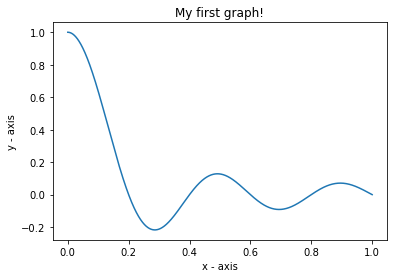

In [4]:
step = 0.1
X = np.linspace(1e-4, 1, 2500) 
y = np.sin(5*np.pi*X) / (5*np.pi*X)

import matplotlib.pyplot as plt
plt.plot(X, y)
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('My first graph!')
 
# function to show the plot
plt.show()



In [5]:
LR = 1e-4
MAX_EPOCH = 20000
BATCH_SIZE = 512

X_train, X_val, y_train, y_val = map(torch.tensor, train_test_split(X, y, test_size=0.2))
#X_train=torch.tensor(X)
#y_train=torch.tensor(y)
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)






In [6]:
def returnLossPredictedOp(model, train_dataloader, val_dataloader):
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    
    # training loop
    train_loss_list = list()
    val_loss_list = list()
    actual_x=[]
    predicted_y=[]
    org_y=[]
    grad_norm=[]
    for epoch in range(20):
        print("epoch %d / %d" % (epoch+1, MAX_EPOCH))
        model.train()
        actual_x=[]
        predicted_y=[]
        org_y=[]
        # training loop
        temp_loss_list = list()
        for X_train, y_train in train_dataloader:
            X_train = X_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.float32).to(device)

            optimizer.zero_grad()

            score = model(X_train)

            actual_x.append(X_train.detach().cpu().numpy())
            predicted_y.append(score.detach().cpu().numpy())
            org_y.append(y_train.detach().cpu().numpy())

            loss = criterion(input=score, target=y_train)
            #loss.requires_grad = True
            loss.backward()

            optimizer.step()

            temp_loss_list.append(loss.detach().cpu().numpy())

        train_loss_list.append(np.average(temp_loss_list))
        grad_all=0
        for p in model.parameters():
            grad=0
            if p.grad is not None:
                grad=(p.grad.cpu().data.numpy()**2).sum()
            grad_all+=grad
            
        grad_norm.append(grad_all**0.5)
        # validation
        model.eval()

        temp_loss_list = list()

        for X_val, y_val in val_dataloader:
            X_val = X_val.type(torch.float32).to(device)
            y_val = y_val.type(torch.float32).to(device)

            score = model(X_val)        
            loss = criterion(input=score, target=y_val)

            temp_loss_list.append(loss.detach().cpu().numpy())

        val_loss_list.append(np.average(temp_loss_list))

        print("\ttrain loss: %.5f" % train_loss_list[-1])
        print("\tval loss: %.5f" % val_loss_list[-1])
    
    return actual_x, org_y, predicted_y, train_loss_list, val_loss_list, grad_norm





In [7]:
model1 = SineApproximator().to(device)
ac_x_1, ac_y_1, p_y_1, t_ls_1, v_ls_1, grad_norm = returnLossPredictedOp(model1, train_dataloader, val_dataloader)



/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


epoch 1 / 20000


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

NameError: name 'np' is not defined

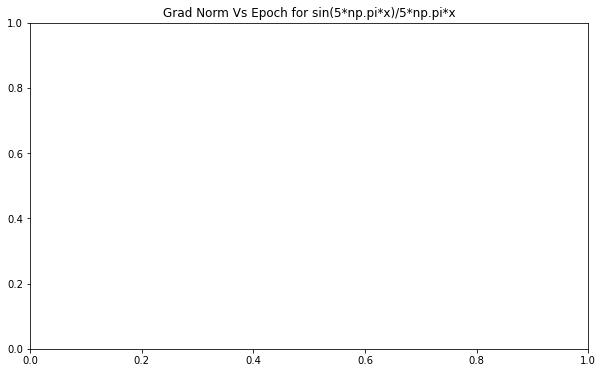

In [1]:
import matplotlib.pyplot as plt

plt_1 = plt.figure(figsize=(10, 6))

plt.title("Grad Norm Vs Epoch for sin(5*np.pi*x)/5*np.pi*x")

plt.plot(np.array(grad_norm), alpha=1)
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


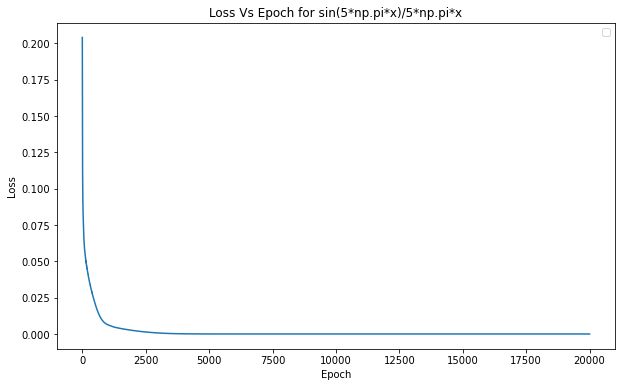

In [16]:
plt_1 = plt.figure(figsize=(10, 6))

plt.title("Loss Vs Epoch for sin(5*np.pi*x)/5*np.pi*x")

plt.plot(np.array(t_ls_1), alpha=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

In [6]:
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 512}
test_kwargs = {'batch_size': 512}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [7]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2704, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



In [8]:
def train( model, device, train_loader, optimizer,loss_fn, epoch):
    train_loss=0
    model.train()
    no_batches=0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        #train_loss.append(sum(loss.detach().cpu().numpy())/len(data))
        train_loss+=loss.item()
        no_batches+=1
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    print("Epoch:", epoch, "sum loss:", train_loss, "batches", no_batches, "loss:", train_loss/no_batches,
         "accuracy:", 100. * correct / len(train_loader.dataset))  
    return train_loss/no_batches, 100. * correct / len(train_loader.dataset)

def returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch):
    train_loss=[]
    test_loss=[]
    accuracy_train=[]
    accuracy_test=[]
    grad_norm=[]
    for epoch in range(1, epoch+1):
        tr_loss, tr_accuracy=train(model, device, train_loader, optimizer, loss, epoch)
        train_loss.append(tr_loss)
        accuracy_train.append(tr_accuracy)
        grad_all=0
        for p in model.parameters():
            grad=0
            if p.grad is not None:
                grad=(p.grad.cpu().data.numpy()**2).sum()
            grad_all+=grad
            
        grad_norm.append(grad_all**0.5)

    return train_loss, accuracy_train, grad_norm

In [ ]:
epoch=500
model = CnnNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()
t_ls_2, t_ac_2, grad_norm = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch )


Epoch: 1 sum loss: 263.9350674152374 batches 118 loss: 2.2367378594511647 accuracy: 25.748333333333335
Epoch: 2 sum loss: 237.1533899307251 batches 118 loss: 2.0097744909383484 accuracy: 49.876666666666665
Epoch: 3 sum loss: 195.27939569950104 batches 118 loss: 1.654910133046619 accuracy: 60.36333333333334
Epoch: 4 sum loss: 152.565868973732 batches 118 loss: 1.2929310929977287 accuracy: 66.87
Epoch: 5 sum loss: 122.3876690864563 batches 118 loss: 1.0371836363259008 accuracy: 71.655
Epoch: 6 sum loss: 103.93211674690247 batches 118 loss: 0.8807806503974785 accuracy: 74.99166666666666
Epoch: 7 sum loss: 92.22524744272232 batches 118 loss: 0.7815698935823926 accuracy: 77.30833333333334
Epoch: 8 sum loss: 83.75352770090103 batches 118 loss: 0.7097756584822121 accuracy: 79.03833333333333
Epoch: 9 sum loss: 78.1728435754776 batches 118 loss: 0.6624817252159119 accuracy: 80.22333333333333
Epoch: 10 sum loss: 73.59878200292587 batches 118 loss: 0.6237184915502193 accuracy: 81.41166666666666
E

No handles with labels found to put in legend.


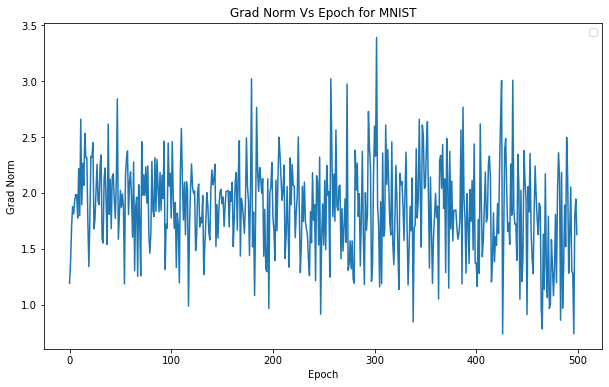

In [16]:
import matplotlib.pyplot as plt

plt_1 = plt.figure(figsize=(10, 6))

plt.title("Grad Norm Vs Epoch for MNIST")

plt.plot(np.array(grad_norm))
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
 
plt.show()


No handles with labels found to put in legend.


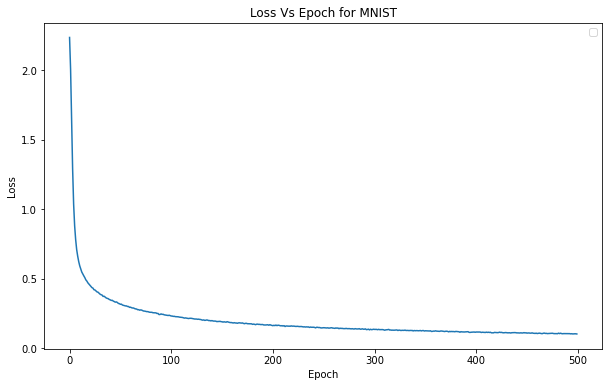

In [14]:
plt_1 = plt.figure(figsize=(10, 6))

plt.title("Loss Vs Epoch for MNIST")

plt.plot(np.array(t_ls_2), alpha=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

No handles with labels found to put in legend.


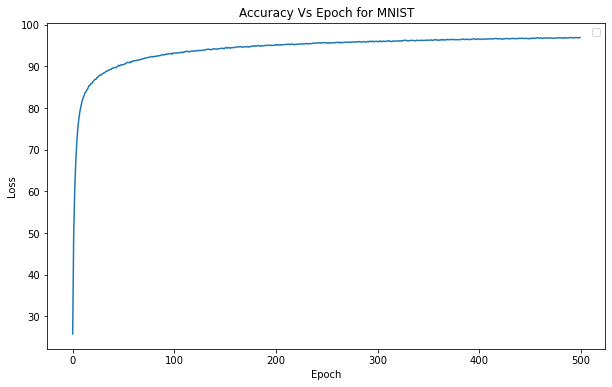

In [15]:
plt_1 = plt.figure(figsize=(10, 6))

plt.title("Accuracy Vs Epoch for MNIST")

plt.plot(np.array(t_ac_2), alpha=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
plt.show()